In [1]:
import sys
sys.path.append('../..')
from consecution import Node, Pipeline, GlobalState, Clock
from collections import namedtuple, defaultdict
import datetime
from dateutil.parser import parse
import glob
import csv
import itertools
from __future__ import print_function




# Simple Linear Pipeline


Pipeline
--------------------------------------------------------------------
 one | two
 two | tree
--------------------------------------------------------------------



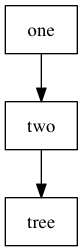

N(one)           processing A
N(two)           processing A
N(tree)          processing A
N(one)           processing B
N(two)           processing B
N(tree)          processing B


In [2]:
class N(Node):
    def process(self, rec):
        print('{:<16} processing {}'.format(self, rec))
        self.push(rec)
        
one = N('one')
two = N('two')
three = N('tree')

one.add_downstream(two)
two.add_downstream(three)
pipe = Pipeline(one)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))


Pipeline
--------------------------------------------------------------------
  one | two
  two | three
--------------------------------------------------------------------



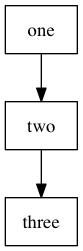

N(one)           processing A
N(two)           processing A
N(three)         processing A
N(one)           processing B
N(two)           processing B
N(three)         processing B


In [3]:
class N(Node):
    def process(self, rec):
        print('{:<16} processing {}'.format(self, rec))
        self.push(rec)
        
pipe = Pipeline(
    N('one') | N('two') | N('three')
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))

# Broadcast to downstream nodes


Pipeline
--------------------------------------------------------------------
  one | two
  two | [left, right]
--------------------------------------------------------------------



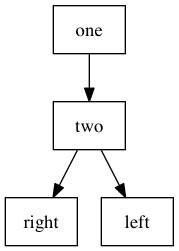

N(one)           processing A
N(two)           processing A
N(left)          processing A
N(right)         processing A
N(one)           processing B
N(two)           processing B
N(left)          processing B
N(right)         processing B


In [4]:
pipe = Pipeline(
    N('one') | N('two') | [N('left'), N('right')]
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))

# Merging branches


Pipeline
--------------------------------------------------------------------
  one | two
  two | [left, right]
 left | join
right | join
--------------------------------------------------------------------



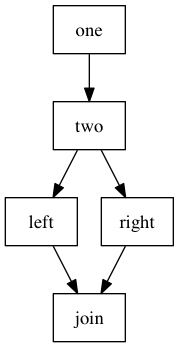

N(one)           processing A
N(two)           processing A
N(left)          processing A
N(join)          processing A
N(right)         processing A
N(join)          processing A
N(one)           processing B
N(two)           processing B
N(left)          processing B
N(join)          processing B
N(right)         processing B
N(join)          processing B


In [5]:
pipe = Pipeline(
    N('one') | N('two') | [N('left'), N('right')] | N('join')
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))


Pipeline
--------------------------------------------------------------------
       one | two
       two | two.router
two.router | [handle_A, handle_B]
  handle_A | join
  handle_B | join
--------------------------------------------------------------------



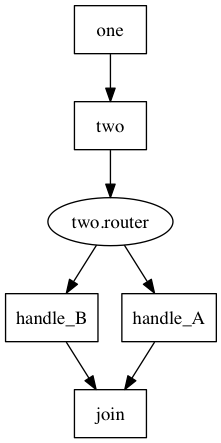

N(one)           processing A
N(two)           processing A
N(handle_A)      processing A
N(join)          processing A
N(one)           processing B
N(two)           processing B
N(handle_B)      processing B
N(join)          processing B


In [6]:
def router(item):
    return 'handle_A' if item == 'A' else 'handle_B'
pipe = Pipeline(
    N('one') | N('two') | [N('handle_A'), N('handle_B'), router] | N('join')
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))


Pipeline
--------------------------------------------------------------------
one | two
--------------------------------------------------------------------



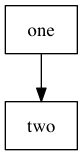

one beginning
two beginning
N(one)           processing A
N(one)           processing B
N(two)           processing A
N(two)           processing B
one ending
two ending


In [7]:
class M(Node):
    def begin(self):
        print('{} beginning'.format(self.name))
        self.records = []
    
    def process(self, rec):
        print('{:<16} processing {}'.format(self, rec))
        self.records.append(rec)
        
    def end(self):
        for rec in self.records:
            self.push(rec)
        print('{} ending'.format(self.name))
        
pipe = Pipeline(
    M('one') | M('two')
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))


Pipeline
--------------------------------------------------------------------
one | two
--------------------------------------------------------------------



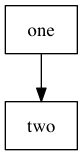

pipeline beginning
one beginning
two beginning
N(one)           processing A
N(two)           processing A
N(one)           processing B
N(two)           processing B
one ending
two ending
pipeline ending


In [8]:
class M(Node):
    def begin(self):
        print('{} beginning'.format(self.name))
    
    def process(self, rec):
        print('{:<16} processing {}'.format(self, rec))
        self.push(rec)
        
    def end(self):
        print('{} ending'.format(self.name))

class CustomPipeline(Pipeline):
    def begin(self):
        print('pipeline beginning')

    def end(self):
        print('pipeline ending')
        
pipe = CustomPipeline(
    M('one') | M('two')
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.consume(list('AB'))


Pipeline
--------------------------------------------------------------------
one | two
--------------------------------------------------------------------



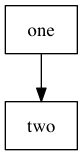

set(['A', 'B'])


In [9]:
class P(Node):
    def process(self, rec):
        self.global_state.records_seen.add(rec)
        self.push(rec)

class CustomPipeline(Pipeline):
    def begin(self):
        self.global_state.records_seen = set()

    def end(self):
        return self.global_state.records_seen
        
pipe = CustomPipeline(
    P('one') | P('two')
)
print(pipe)
pipe.plot(display_noteook=True)

results = pipe.consume(list('AB'))
print(results)


Pipeline
--------------------------------------------------------------------
one | two
--------------------------------------------------------------------



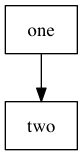

set(['A', 'B'])


In [10]:
class P(Node):
    def process(self, rec):
        self.global_state.records_seen.add(rec)
        self.push(rec)

class CustomPipeline(Pipeline):
    def begin(self):
        self.global_state.records_seen = set()

    def end(self):
        return self.global_state.records_seen
        
pipe = CustomPipeline(
    P('one') | P('two')
)
print(pipe)
pipe.plot(display_noteook=True)

pipe.push('A')
pipe.push('B')
results = pipe.end()

print(results)

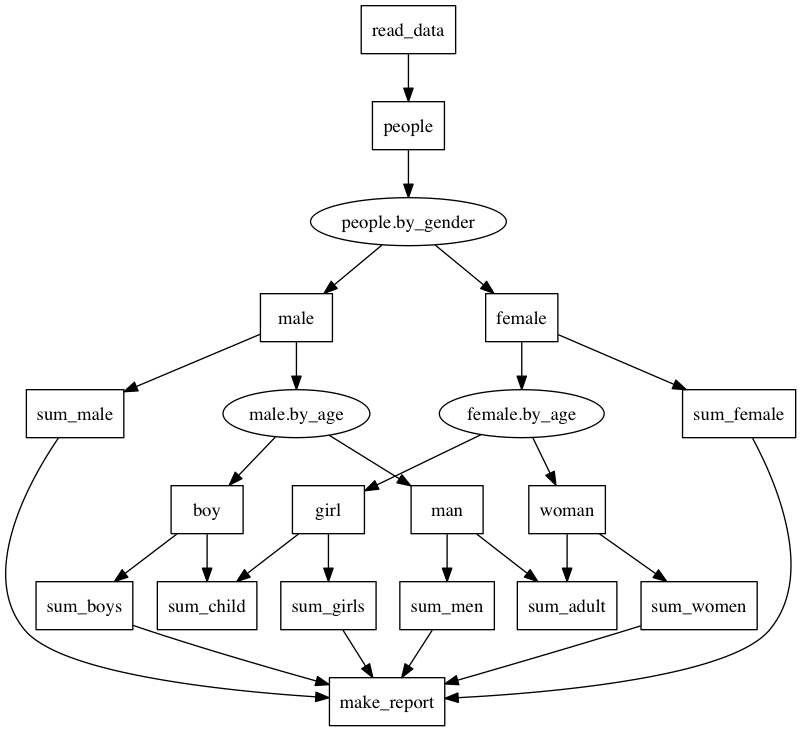

In [11]:
def by_gender(item):
    return
def by_age(item):
    return

make_report = N('make_report')
p = Pipeline(
    N('read_data') | N('people')
    | [
        N('male') | [N('man') | N('sum_men'),
        N('boy') | N('sum_boys')
        ,by_age
      ], 
     N('female') | [N('woman') | N('sum_women'), N('girl') | N('sum_girls'), by_age],
        by_gender
        
    ]
    | make_report
)

sum_female = N('sum_female')
sum_male = N('sum_male')
sum_adult = N('sum_adult')
sum_child = N('sum_child')
p['male'].add_downstream(sum_male)
p['female'].add_downstream(sum_female)
p['woman'].add_downstream(sum_adult)
p['man'].add_downstream(sum_adult)
p['boy'].add_downstream(sum_child)
p['girl'].add_downstream(sum_child)
sum_male.add_downstream(make_report)
sum_female.add_downstream(make_report)

p.plot(display_noteook=True)

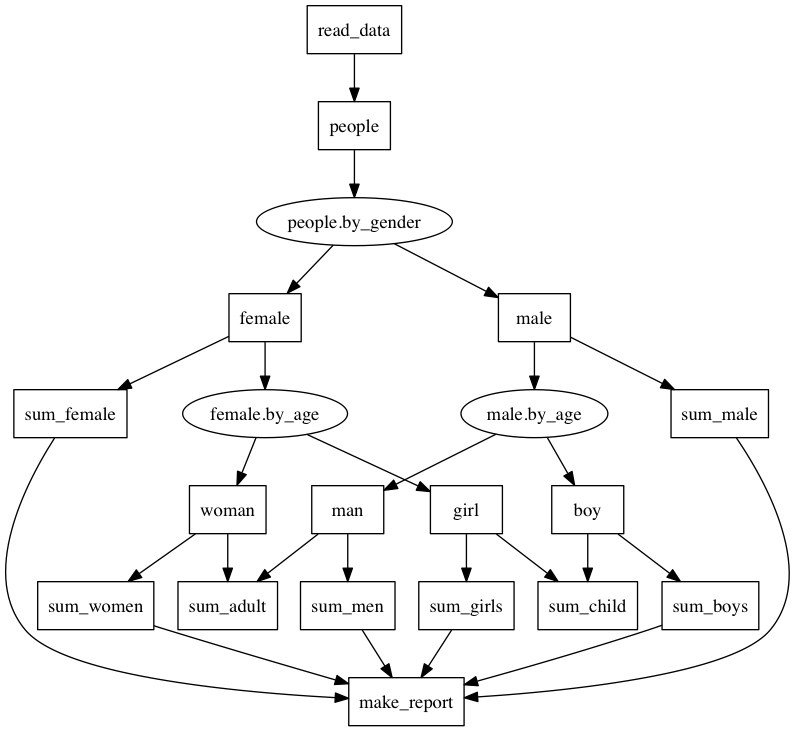

In [12]:
def by_gender(item):
    return
def by_age(item):
    return

make_report = N('make_report')
p = Pipeline(
    N('read_data') | N('people')
    | [
        N('male') 
        | [
            N('man') | N('sum_men'),
            N('boy') | N('sum_boys'),
            by_age
          ], 
        N('female') 
        | [
            N('woman') | N('sum_women'), 
            N('girl') | N('sum_girls'), 
            by_age
        ],
        by_gender
    ]
    | make_report
)

sum_female = N('sum_female')
sum_male = N('sum_male')
sum_adult = N('sum_adult')
sum_child = N('sum_child')
p['male'].add_downstream(sum_male)
p['female'].add_downstream(sum_female)
p['woman'].add_downstream(sum_adult)
p['man'].add_downstream(sum_adult)
p['boy'].add_downstream(sum_child)
p['girl'].add_downstream(sum_child)
sum_male.add_downstream(make_report)
sum_female.add_downstream(make_report)

p.plot(display_noteook=True)

In [18]:
def by_gender(item):
    return
def by_age(item):
    return

make_report = N('make_report')
sum_child = N('sum_child')
sum_adult = N('sum_adult')
p = Pipeline(
    N('read_data') | N('people')
    | 
      [
        N('male') | N('sum_male'),
        N('female') | N('sum_female'), 
        by_gender
      ]
    #| make_report
)
p.add_branch(
    'female',
    [
        N('woman') | [N('sum_women'), sum_adult],# | make_report, 
        N('girl') | [N('sum_girls'), sum_child], # | make_report,
        by_age
    ]
)
p.add_branch(
    'male',
    [
        N('men') | [N('sum_men'), sum_adult],# | make_report, 
        N('boy') | [N('sum_boys'), sum_child], # | make_report,
        by_age
    ]
)

# sum_female = N('sum_female')
# sum_male = N('sum_male')
# sum_adult = N('sum_adult')
# sum_child = N('sum_child')
# p['male'].add_downstream(sum_male)
# p['female'].add_downstream(sum_female)
# p['woman'].add_downstream(sum_adult)
# p['man'].add_downstream(sum_adult)
# p['boy'].add_downstream(sum_child)
# p['girl'].add_downstream(sum_child)
# sum_male.add_downstream(make_report)
# sum_female.add_downstream(make_report)

p.plot(display_noteook=True)

ValueError: 

Your graph is not acyclic.  It has loops.